In [35]:
import os
import pandas as pd
import numpy as np
import umap

pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',200)

DATA_DIR="Data/OnlineNewsPopularity/"

In [18]:
meta=pd.read_csv("Articles_meta.csv")
embs=np.load("infersent_embs.npy")
scores=pd.read_csv("readability.csv")

## For infersent models

In [19]:
df=pd.read_csv(DATA_DIR+"OnlineNewsPopularity.csv")
to_remove=[" timedelta", 
#     " data_channel_is_lifestyle",
#     " data_channel_is_entertainment",
#     " data_channel_is_bus",
#     " data_channel_is_socmed",
#     " data_channel_is_tech",
#     " data_channel_is_world",
    " kw_min_min",
    " kw_max_min",
    " kw_avg_min",
    " kw_min_max",
    " kw_max_max",
    " kw_avg_max",
    " kw_min_avg",
    " kw_max_avg",
    " kw_avg_avg",
    ' self_reference_min_shares',
    ' self_reference_max_shares',
    ' self_reference_avg_sharess',]
#     " LDA_00",
#     " LDA_01",
#     " LDA_02",
#     " LDA_03",
#     " LDA_04"]
df=df.drop(to_remove, axis=1)
df[' shares']=(df[' shares']>=1400).astype(int)
meta=meta.dropna()
df=df[df['url'].isin(meta['url'])].reset_index(drop=True)
df_y=df[' shares'].values

df_X=df.drop(['url', ' shares'], axis=1)
cols=df_X.columns.tolist()+scores.iloc[:,1:].columns.tolist()+[str(i) for i in range(25)]
df_X=np.concatenate([df_X, scores.iloc[:,1:].values, embs], axis=1)
df_X.shape

(39606, 4145)

## For custom preprocessed + readability models

In [36]:
# df_new=pd.read_csv("df_preprocessed.csv")
# df=pd.read_csv(DATA_DIR+"OnlineNewsPopularity.csv")
# readability=pd.read_csv("readability.csv")
# df=df_new.merge(df[['url', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' shares']] ,
# #                     " data_channel_is_lifestyle",
# #                     " data_channel_is_entertainment",
# #                     " data_channel_is_bus",
# #                     " data_channel_is_socmed",
# #                     " data_channel_is_tech",
# #                     " data_channel_is_world"]], 
#                 on='url')
# df=df.merge(readability, on='url')

# df_y=(df[' shares']>=1400).astype(int).values
# df_X=df.drop(['url', ' shares'], axis=1).values
# df_X.shape

(39585, 46)

## Original raw dataset

In [8]:
# df=pd.read_csv(DATA_DIR+"OnlineNewsPopularity.csv")

# df_y=(df[' shares']>=1400).astype(int).values
# df_X=df.drop(['url', ' shares'], axis=1).values
# df_X.shape

(39644, 59)

In [20]:
del embs
del meta
del df
del scores

In [21]:
import gc
gc.collect()

192

In [22]:
from sklearn.model_selection import train_test_split

ptrain_X, ptest_X, train_y, test_y=train_test_split(df_X, df_y, test_size=0.2, random_state=169, shuffle=True)
del df_X, df_y
dim_red=umap.UMAP(n_neighbors=20, min_dist=0.25, n_components=25, metric='cosine')
dim_red=dim_red.fit(ptrain_X[:,:-4096])

In [23]:
gc.collect()
train_X=np.concatenate([ptrain_X[:,:-4096], dim_red.transform(ptrain_X[:,-4096:])], axis=1)
del ptrain_X
gc.collect()

34088

In [24]:
test_X=np.concatenate([ptest_X[:,:-4096], dim_red.transform(ptest_X[:,-4096:])], axis=1)
del ptest_X
gc.collect()

36154

In [37]:
# from sklearn.model_selection import train_test_split

# train_X, test_X, train_y, test_y=train_test_split(df_X, df_y, test_size=0.2, random_state=169, shuffle=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


def checkdir(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def evaluate(clf, test_X, test_y, preds=None):
    if preds is None:
        preds=clf.predict(test_X)
    acc=accuracy_score(test_y, preds)
    print(classification_report(test_y, preds))
    print("Accuracy:",acc)
    return accuracy_score(test_y, preds)


classifiers = []

classifiers+=[[LogisticRegression(max_iter=500), "Log"]]
classifiers+=[[DecisionTreeClassifier(max_depth=4),"CART"]]
classifiers+=[[RandomForestClassifier(max_depth=4, n_estimators=200),"RF"]]
classifiers+=[[MLPClassifier(alpha=1, max_iter=1000),"MLP"]]
classifiers+=[[XGBClassifier(n_estimators=32, max_depth=5, learning_rate=0.1, n_jobs=4), "XGBoost"]]

for clf, clfN in classifiers:
    clf.fit(train_X,train_y)
    print("\n"+clfN)
    evaluate(clf, test_X, test_y)

In [17]:
import pickle
classifiers[-1][0].save_model("models/xgb.model")


In [21]:
with open("models/xgb.model", 'wb') as f:
    f.write(pickle.dumps(classifiers[-1][0]))
    
with open("models/rf.model", 'wb') as f:
    f.write(pickle.dumps(classifiers[-3][0]))

In [26]:
xgb=pickle.load(open("models/xgb.model","rb"))
evaluate(xgb,test_X, test_y)

              precision    recall  f1-score   support

           0       0.62      0.54      0.58      3783
           1       0.62      0.69      0.66      4134

    accuracy                           0.62      7917
   macro avg       0.62      0.62      0.62      7917
weighted avg       0.62      0.62      0.62      7917

Accuracy: 0.6205633447012757


0.6205633447012757

# Initial Results

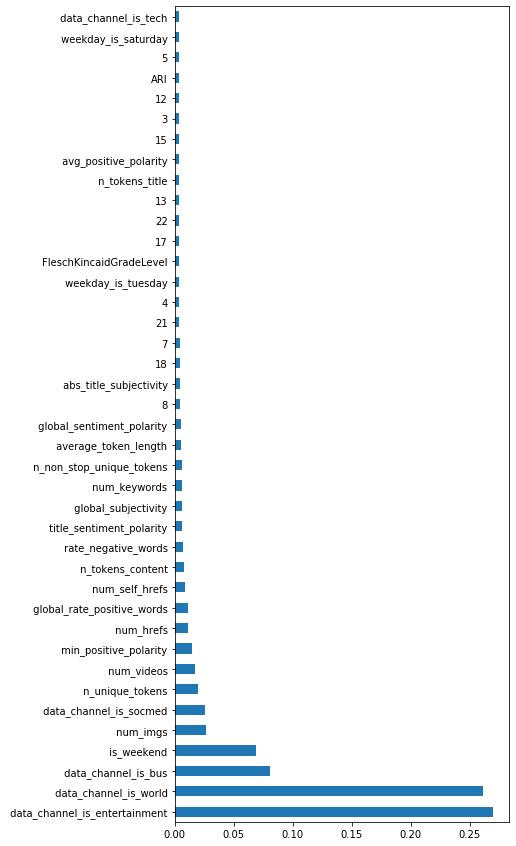

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,15))
feat_importances = pd.Series(classifiers[-1][0].feature_importances_, index=cols[:79])

feat_importances.nlargest(40).plot(kind='barh')